In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib notebook

#load the files
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')

#size of training dataset
train_samples = train.shape[0]

In [2]:
train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [3]:
train.Embarked.unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [4]:
train.groupby(by='Survived').PassengerId.count()

# double number of not survived that survived

Survived
0    549
1    342
Name: PassengerId, dtype: int64

In [5]:
#from mpl_toolkits.mplot3d import Axes3D

#ax3d = plt.figure().gca(projection='3d')
#ax3d.scatter(train.SibSp, train.Parch, train.Age, c=train.Survived, alpha=0.5)

In [6]:
train.isna().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool

In [7]:
train.Name.apply(lambda s: s.split(". ")[0].split(", ")[1]  ).unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

In [11]:
train.groupby(by=['Name2','Sex','Pclass']).Age.mean()

Name2         Sex     Pclass
Capt          male    1         70.000000
Col           male    1         58.000000
Don           male    1         40.000000
Dr            female  1         49.000000
              male    1         42.000000
                      2         38.500000
Jonkheer      male    1         38.000000
Lady          female  1         48.000000
Major         male    1         48.500000
Master        male    1          5.306667
                      2          2.258889
                      3          5.350833
Miss          female  1         30.000000
                      2         22.390625
                      3         16.123188
Mlle          female  1         24.000000
Mme           female  1         24.000000
Mr            male    1         41.580460
                      2         32.768293
                      3         28.724891
Mrs           female  1         40.882353
                      2         33.682927
                      3         33.515152
Ms   

In [44]:
#train['Name2'] = train.Name.apply(lambda s: s.split(". ")[0].split(", ")[1]  )
#gg = train.groupby(by='Name2').Age.mean()
#gg = train.groupby(by=['Name2','Sex']).Age.mean()
#print(gg['Capt','male'])
#train['Age2'] = np.where(train.Age.isnull(), gg[train.Name2, train.Sex], train.Age)
#train

In [45]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

def preprocess(df, fit_scaler=True):
    #X = df[['Pclass','Age','SibSp','Parch','Fare','Sex', 'Embarked']]
    X = df[['Pclass','Sex', 'Age']].copy()

    # feature engineering
    X.Sex = X.Sex.map({'female':1, 'male':0})
    #X.Embarked.fillna('U', inplace=True)
    #X.Embarked = X.Embarked.map({'S':0,'C':1,'Q':2,'U':3})
    
    X['Family'] = 0
    mask = (df.Parch>0) & (df.SibSp>0)
    X.loc[mask, 'Family'] = 1
    
    X['Name'] = train.Name.apply(lambda s: s.split(". ")[0].split(", ")[1])
    list_names = train.Name.apply(lambda s: s.split(". ")[0].split(", ")[1]).unique()
    dict_names = {v:k for k,v in enumerate(list_names)}
    X.Name = X.Name.map(dict_names)
    
    #fill NaN Age with the mean of the same name ('Mr', 'Miss',...)
    grp_name_age = X.groupby(by='Name').Age.mean()
    X['Age'] = np.where(X.Age.isnull(), grp_name_age[X.Name], X.Age)
    
    X = X.drop('Name',axis=1)
    
    # Note the way of scaling (df[df.columns])
    # we want to mantain the dataframe (instead of numpy array)
    if fit_scaler:
        X[X.columns] = scaler.fit_transform(X[X.columns])
    else:
        X[X.columns] = scaler.transform(X[X.columns])
    return X


X_train = preprocess(train)
y_train = train[['Survived']]

<IPython.core.display.Javascript object>


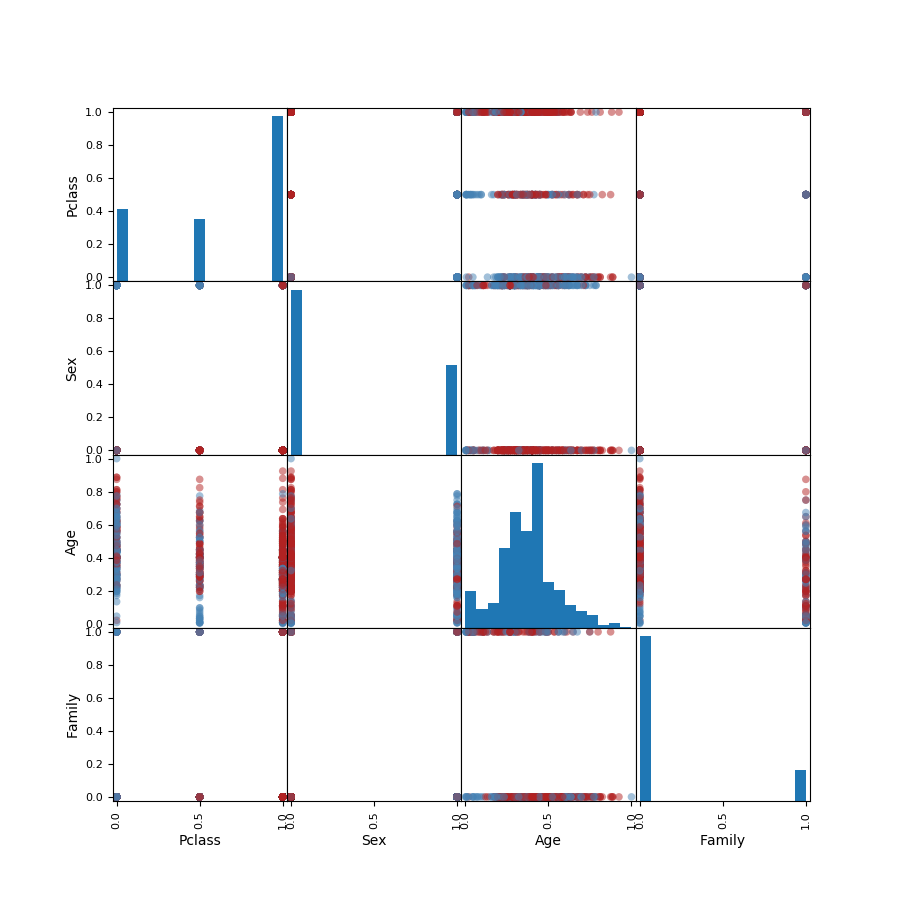

In [46]:
# plotting a scatter matrix
colormap = {0:'firebrick',1:'steelblue'}
colors = y_train.Survived.map(colormap)

pd.plotting.scatter_matrix(X_train, c=colors, marker = 'o', s=30,
                           hist_kwds={'bins':15}, figsize=(9,9));



In [47]:
#baseline
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report

def baseline(X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0)

    dummy = DummyClassifier(random_state=0)

    #be aware of y as column vector
    dummy.fit(X_train, y_train.values.reshape(-1))
    acc = dummy.score(X_val.values, y_val.values.reshape(-1))
    print('Accuracy: {:.2f}\n'.format(acc))
    
    # Combined report with all above metrics
    print(classification_report(y_val, dummy.predict(X_val), target_names=['Not Survived', 'Survived']))

#baseline(X_train, y_train)

In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

X_train_1 = X_train.values
y_train_1 = y_train.values.reshape(-1)

rfc = RandomForestClassifier(random_state=0)
scores = cross_validate(rfc, X_train_1, y_train_1, cv=10, scoring='accuracy')

print("Train scores: {:.3f}".format(scores['train_score'].mean()))
print("Test scores: {:.3f}".format(scores['test_score'].mean()))

Train scores: 0.892
Test scores: 0.820


In [49]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, auc, accuracy_score

def grid_search(X, y):  
    X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0)
    params = {'n_estimators': [2, 3, 5, 7, 10, 15, 20],
              'class_weight': ['balanced', {1:2}, {1:3}],
              'max_features': [1,2,3,4],
              'max_depth': [1,2,3,4,None]}

    grid_rfc = GridSearchCV(rfc, param_grid=params, cv=10, scoring='accuracy')
    grid_rfc.fit(X_train, y_train)

    best_rfc = grid_rfc.best_estimator_

    y_pred = best_rfc.predict(X_val)
    print("Accuracy: {:.3f}".format(accuracy_score(y_val, y_pred)))

    y_probs = best_rfc.predict_proba(X_val)
    auc = roc_auc_score(y_val, y_probs[:,1])
    print("AUC:{:.3f}".format(auc))
    
    print("Best params:\n {}".format(grid_rfc.best_params_))
    print(classification_report(y_val, y_pred, target_names=['Not Survived', 'Survived']))
    
    return best_rfc

best_rfc = grid_search(X_train_1, y_train_1)

Accuracy: 0.794
AUC:0.875
Best params:
 {'n_estimators': 5, 'max_features': 2, 'class_weight': 'balanced', 'max_depth': 4}
              precision    recall  f1-score   support

Not Survived       0.82      0.86      0.84       139
    Survived       0.75      0.68      0.71        84

 avg / total       0.79      0.79      0.79       223



In [50]:
scores = cross_validate(best_rfc, X_train_1, y_train_1, cv=10, scoring='accuracy')

print("Train scores: {:.3f}".format(scores['train_score'].mean()))
print("Test scores: {:.3f}".format(scores['test_score'].mean()))

best_rfc.fit(X_train_1, y_train_1)
scores = cross_validate(best_rfc, X_train_1, y_train_1, cv=10, scoring='accuracy')

print("Train scores: {:.3f}".format(scores['train_score'].mean()))
print("Test scores: {:.3f}".format(scores['test_score'].mean()))

Train scores: 0.831
Test scores: 0.806
Train scores: 0.831
Test scores: 0.806


In [51]:
import os

X_test = preprocess(test, fit_scaler=False)
predictions = best_rfc.predict(X_test)

passengerId = 892
file = "PassengerId,Survived" + os.linesep

for i in range(len(X_test)):
    file += "{},{}".format(passengerId, (int)(predictions[i]))  + os.linesep
    passengerId += 1
    
# Save to file
with open('attempt.txt', 'w') as f:
    f.write(file)